In [2]:
import matplotlib.pyplot as plt
import numpy as np

import error_generators as _eg
from IPython.display import display
from importlib import reload
from scipy.linalg import expm, logm
import sympy as _sp

In [3]:
from pygsti.modelpacks import smq1Q_XYZI as std
target_model = std.target_model()
meas_0 = target_model[('Mdefault')]['0'].to_dense()
meas_1 = target_model[('Mdefault')]['1'].to_dense()
rho0 = target_model['rho0']
rho0.depolarize(0.1)
rho0 = rho0.to_dense()
mat_Gx = np.round(target_model[('Gxpi2', 0)].to_dense(), 3)

In [4]:
rho0

array([0.70710678, 0.        , 0.        , 0.6363961 ])

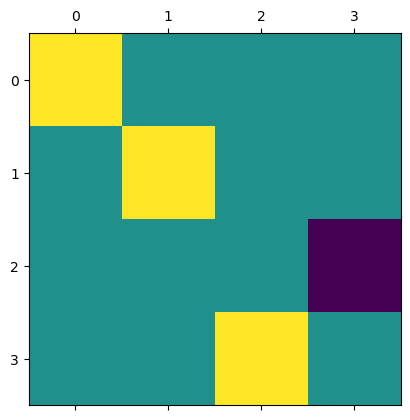

In [5]:
plt.matshow((mat_Gx))

In [6]:
# investigating the pygsti superop_for_perfeact_twirl
def _super_op_for_perfect_twirl(wrt, eps):
    """Return super operator for doing a perfect twirl with respect to wrt.
    """
    assert wrt.shape[0] == wrt.shape[1]  # only square matrices allowed
    dim = wrt.shape[0]
    SuperOp = np.zeros((dim**2, dim**2), 'complex')

    # Get spectrum and eigenvectors of wrt
    wrtEvals, wrtEvecs = np.linalg.eig(wrt)
    wrtEvecsInv = np.linalg.inv(wrtEvecs)

    # We want to project  X -> M * (Proj_i * (Minv * X * M) * Proj_i) * Minv,
    # where M = wrtEvecs. So A = B = M * Proj_i * Minv and so
    # superop = A tensor B^T == A tensor A^T
    # NOTE: this == (A^T tensor A)^T while *Maple* germ functions seem to just
    # use A^T tensor A -> ^T difference
    for i in range(dim):
        # Create projector onto i-th eigenspace (spanned by i-th eigenvector
        # and other degenerate eigenvectors)
        Proj_i = np.diag([(1 if (abs(wrtEvals[i] - wrtEvals[j]) <= eps)
                            else 0) for j in range(dim)])
        A = np.dot(wrtEvecs, np.dot(Proj_i, wrtEvecsInv))
        #if _np.linalg.norm(A.imag) > 1e-6:
        #    print("DB: imag = ",_np.linalg.norm(A.imag))
        #assert(_np.linalg.norm(A.imag) < 1e-6)
        #A = _np.real(A)
        # Need to normalize, because we are overcounting projectors onto
        # subspaces of dimension d > 1, giving us d * Proj_i tensor Proj_i^T.
        # We can fix this with a division by tr(Proj_i) = d.
        SuperOp += np.kron(A, A.T) / np.trace(Proj_i)
        # SuperOp += _np.kron(A.T,A) # Mimic Maple version (but I think this is
        # wrong... or it doesn't matter?)
    return SuperOp  # a op_dim^2 x op_dim^2 matrix

In [7]:
reload(_eg)

<module 'error_generators' from '/home/jpmarceaux/VSProjects/ErrorGenerators/error_generators.py'>

In [8]:
ebasis = _eg.EEBasis(1)

/home/jpmarceaux/anaconda3/envs/ErrorGenerators/lib/python3.10/site-packages/pygsti/modelmembers/operations/lindbladerrorgen.py:1691: UserWarning: Using 'CPTP' as a Lindblad type is deprecated, and you should now use 'CPTPLND'
  _warnings.warn("Using 'CPTP' as a Lindblad type is deprecated, and you should now use 'CPTPLND'")


In [9]:
ebasis.mat

Matrix([
[                   0,                                       0,                                       0,                                       0],
[-4.0*{A}^{YxZ}_{Gq0},  -2.0*{S}^{Y}_{Gq0} - 2.0*{S}^{Z}_{Gq0}, 2.0*{C}^{XxY}_{Gq0} - 2.0*{H}^{Z}_{Gq0}, 2.0*{C}^{XxZ}_{Gq0} + 2.0*{H}^{Y}_{Gq0}],
[ 4.0*{A}^{XxZ}_{Gq0}, 2.0*{C}^{XxY}_{Gq0} + 2.0*{H}^{Z}_{Gq0},  -2.0*{S}^{X}_{Gq0} - 2.0*{S}^{Z}_{Gq0}, 2.0*{C}^{YxZ}_{Gq0} - 2.0*{H}^{X}_{Gq0}],
[-4.0*{A}^{XxY}_{Gq0}, 2.0*{C}^{XxZ}_{Gq0} - 2.0*{H}^{Y}_{Gq0}, 2.0*{C}^{YxZ}_{Gq0} + 2.0*{H}^{X}_{Gq0},  -2.0*{S}^{X}_{Gq0} - 2.0*{S}^{Y}_{Gq0}]])

In [10]:
ebasis.mat@mat_Gx - mat_Gx@ebasis.mat

Matrix([
[                                         0,                                                                                  0,                                                                                  0,                                                                                  0],
[                                         0,                                                                                  0, -2.0*{C}^{XxY}_{Gq0} + 2.0*{C}^{XxZ}_{Gq0} + 2.0*{H}^{Y}_{Gq0} + 2.0*{H}^{Z}_{Gq0}, -2.0*{C}^{XxY}_{Gq0} - 2.0*{C}^{XxZ}_{Gq0} - 2.0*{H}^{Y}_{Gq0} + 2.0*{H}^{Z}_{Gq0}],
[-4.0*{A}^{XxY}_{Gq0} + 4.0*{A}^{XxZ}_{Gq0},  2.0*{C}^{XxY}_{Gq0} + 2.0*{C}^{XxZ}_{Gq0} - 2.0*{H}^{Y}_{Gq0} + 2.0*{H}^{Z}_{Gq0},                                                                4.0*{C}^{YxZ}_{Gq0},                                             -2.0*{S}^{Y}_{Gq0} + 2.0*{S}^{Z}_{Gq0}],
[-4.0*{A}^{XxY}_{Gq0} - 4.0*{A}^{XxZ}_{Gq0}, -2.0*{C}^{XxY}_{Gq0} + 2.0*{C}^{XxZ}_{Gq0} - 2.0*{H}

In [11]:
projector = _super_op_for_perfect_twirl(mat_Gx, 1e-8)

In [12]:
ebasis.mat.reshape(16, 1).reshape(4,4)

Matrix([
[                   0,                                       0,                                       0,                                       0],
[-4.0*{A}^{YxZ}_{Gq0},  -2.0*{S}^{Y}_{Gq0} - 2.0*{S}^{Z}_{Gq0}, 2.0*{C}^{XxY}_{Gq0} - 2.0*{H}^{Z}_{Gq0}, 2.0*{C}^{XxZ}_{Gq0} + 2.0*{H}^{Y}_{Gq0}],
[ 4.0*{A}^{XxZ}_{Gq0}, 2.0*{C}^{XxY}_{Gq0} + 2.0*{H}^{Z}_{Gq0},  -2.0*{S}^{X}_{Gq0} - 2.0*{S}^{Z}_{Gq0}, 2.0*{C}^{YxZ}_{Gq0} - 2.0*{H}^{X}_{Gq0}],
[-4.0*{A}^{XxY}_{Gq0}, 2.0*{C}^{XxZ}_{Gq0} - 2.0*{H}^{Y}_{Gq0}, 2.0*{C}^{YxZ}_{Gq0} + 2.0*{H}^{X}_{Gq0},  -2.0*{S}^{X}_{Gq0} - 2.0*{S}^{Y}_{Gq0}]])

In [13]:
commuting_egen = (_sp.Matrix(projector)@ebasis.mat.reshape(16, 1)).reshape(4,4)

In [14]:
commuting_egen

Matrix([
[                   0,                                      0,                                                          0,                                                          0],
[-4.0*{A}^{YxZ}_{Gq0}, -2.0*{S}^{Y}_{Gq0} - 2.0*{S}^{Z}_{Gq0},                                                          0,                                                          0],
[                   0,                                      0, -2.0*{S}^{X}_{Gq0} - 1.0*{S}^{Y}_{Gq0} - 1.0*{S}^{Z}_{Gq0},                                         -2.0*{H}^{X}_{Gq0}],
[                   0,                                      0,                                          2.0*{H}^{X}_{Gq0}, -2.0*{S}^{X}_{Gq0} - 1.0*{S}^{Y}_{Gq0} - 1.0*{S}^{Z}_{Gq0}]])

In [15]:
commuting_egen@mat_Gx - mat_Gx@commuting_egen

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

In [16]:
ebasis.extract_rates(commuting_egen)

100%|██████████| 12/12 [00:00<00:00, 295.55it/s]


{('H', ('X',), (0,)): 1.0*{H}^{X}_{Gq0},
 ('H', ('Y',), (0,)): 0,
 ('H', ('Z',), (0,)): 0,
 ('S', ('X',), (0,)): 1.0*{S}^{X}_{Gq0},
 ('C', ('X', 'Y'), (0,)): 0,
 ('A', ('X', 'Y'), (0,)): 0,
 ('C', ('X', 'Z'), (0,)): 0,
 ('A', ('X', 'Z'), (0,)): 0,
 ('S', ('Y',), (0,)): 0.5*{S}^{Y}_{Gq0} + 0.5*{S}^{Z}_{Gq0},
 ('C', ('Y', 'Z'), (0,)): 0,
 ('A', ('Y', 'Z'), (0,)): 1.0*{A}^{YxZ}_{Gq0},
 ('S', ('Z',), (0,)): 0.5*{S}^{Y}_{Gq0} + 0.5*{S}^{Z}_{Gq0}}

In [54]:
for r in rhos:
    print(SySz@r)

[ 0.  0.  0. -1.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[ 0.  0. -1.  0.]


In [64]:
_sp.simplify(_sp.exp(commuting_egen))

Matrix([
[                                                                                                                                                  1.0,                                               0,                                                                                                                  0,                                                                                                                  0],
[2.0*{A}^{YxZ}_{Gq0}*exp(-2.0*{S}^{Y}_{Gq0} - 2.0*{S}^{Z}_{Gq0})/({S}^{Y}_{Gq0} + {S}^{Z}_{Gq0}) - 2.0*{A}^{YxZ}_{Gq0}/({S}^{Y}_{Gq0} + {S}^{Z}_{Gq0}), 1.0*exp(-2.0*{S}^{Y}_{Gq0} - 2.0*{S}^{Z}_{Gq0}),                                                                                                                  0,                                                                                                                  0],
[                                                                                                                          

In [68]:
_sp.simplify((_sp.exp(commuting_egen)@mat_Gx).eigenvals())

{1.0: 1, 1.0*exp(-2.0*{S}^{Y}_{Gq0})*exp(-2.0*{S}^{Z}_{Gq0}): 1, -sqrt(-(2.0*exp(4.0*I*{H}^{X}_{Gq0}) + 1.0*exp(8.0*I*{H}^{X}_{Gq0}) + 1.0)*exp(8.0*{S}^{X}_{Gq0} + 2*{S}^{Y}_{Gq0} + 2*{S}^{Z}_{Gq0}))*exp(-6.0*{S}^{X}_{Gq0})*exp(-2*{S}^{Y}_{Gq0})*exp(-2*{S}^{Z}_{Gq0})*exp(-2.0*I*{H}^{X}_{Gq0})/2 + 0.5*I*(exp(4.0*I*{H}^{X}_{Gq0}) - 1)*exp(-2.0*I*{H}^{X}_{Gq0} - 2.0*{S}^{X}_{Gq0} - {S}^{Y}_{Gq0} - {S}^{Z}_{Gq0}): 1, sqrt(-(2.0*exp(4.0*I*{H}^{X}_{Gq0}) + 1.0*exp(8.0*I*{H}^{X}_{Gq0}) + 1.0)*exp(8.0*{S}^{X}_{Gq0} + 2*{S}^{Y}_{Gq0} + 2*{S}^{Z}_{Gq0}))*exp(-6.0*{S}^{X}_{Gq0})*exp(-2*{S}^{Y}_{Gq0})*exp(-2*{S}^{Z}_{Gq0})*exp(-2.0*I*{H}^{X}_{Gq0})/2 + 0.5*I*(exp(4.0*I*{H}^{X}_{Gq0}) - 1)*exp(-2.0*I*{H}^{X}_{Gq0} - 2.0*{S}^{X}_{Gq0} - {S}^{Y}_{Gq0} - {S}^{Z}_{Gq0}): 1}

In [70]:
_sp.Matrix(mat_Gx).eigenvals()

{1.00000000000000: 2, -1.0*I: 1, 1.0*I: 1}